In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.author_vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_data = pd.read_pickle('../data/04c_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/Subset_Style_Model.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 10684/10684 [03:55<00:00, 45.42it/s]


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [6]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,0.301,0.260,0.541,0.264,0.371,0.337
1,0.000,0.000,0.311,0.532,0.323,0.396,0.338
2,0.000,0.000,0.000,0.530,0.217,0.268,0.257
3,0.000,0.000,0.000,0.000,0.553,0.584,0.536
4,0.000,0.000,0.000,0.000,0.000,0.294,0.215
5,0.000,0.000,0.000,0.000,0.000,0.000,0.216
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

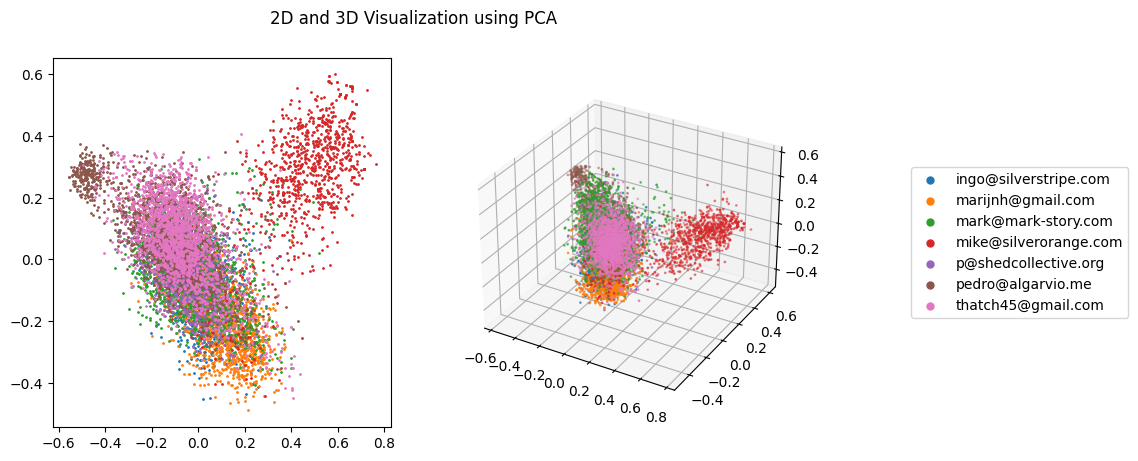

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

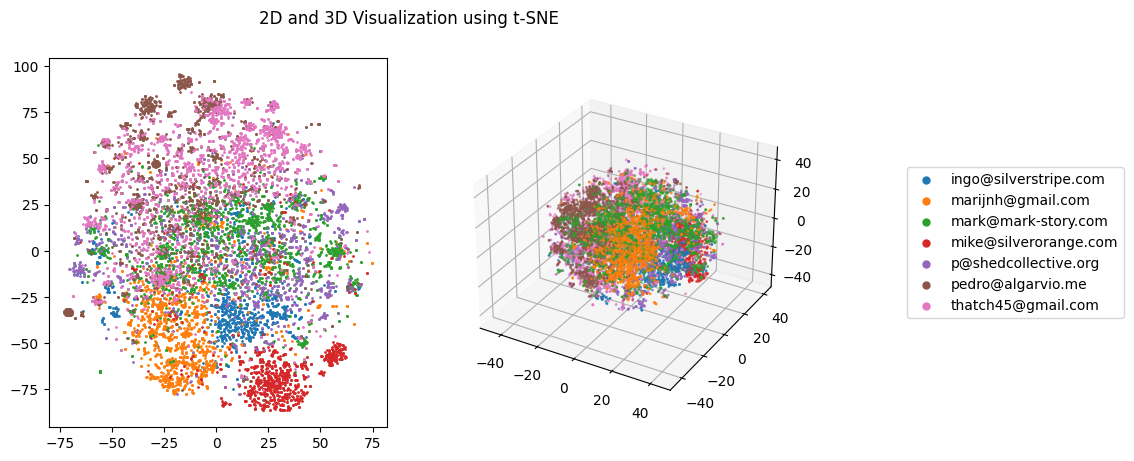

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 4
10 Most common:
[(-1, 7829), (0, 2668), (1, 101), (2, 86)]


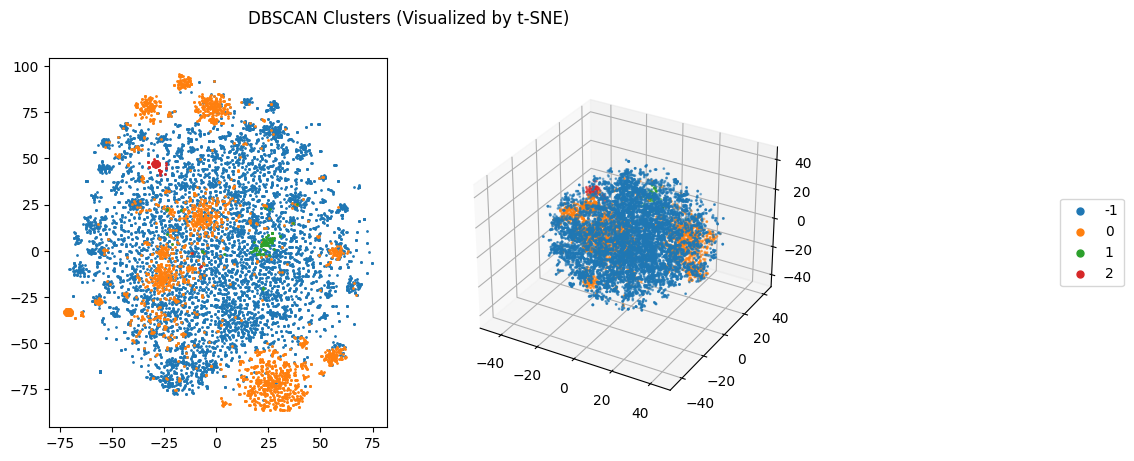

In [9]:
dbscan_model = DBSCAN(eps=1, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,7829.0,7.0,1130.0,"('thatch45@gmail.com', 1658)",90.0,7.0,"('saltstack_salt', 2722)"
1,2668.0,7.0,314.0,"('mike@silverorange.com', 895)",38.0,2.0,"('saltstack_salt', 986)"
2,101.0,6.0,4.0,"('mark@mark-story.com', 62)",20.0,2.0,"('cakephp_cakephp', 59)"
3,86.0,5.0,1.0,"('pedro@algarvio.me', 81)",4.0,1.0,"('saltstack_salt', 83)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,4.000000,4.000000,4.000000,4.000000,4.000000
mean,2671.000000,6.250000,362.250000,38.000000,3.000000
std,3646.555361,0.957427,532.482472,37.345236,2.708013
min,86.000000,5.000000,1.000000,4.000000,1.000000
25%,97.250000,5.750000,3.250000,16.000000,1.750000
50%,1384.500000,6.500000,159.000000,29.000000,2.000000
75%,3958.250000,7.000000,518.000000,51.000000,3.250000
max,7829.000000,7.000000,1130.000000,90.000000,7.000000


In [12]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3
length_mean,81.064376,63.619940,59.891089,58.918605
length_std,62.171804,40.388660,48.811600,32.107456
n_uppercase_mean,3.925278,2.950150,2.019802,1.372093
n_uppercase_std,4.833296,2.581822,2.193511,1.555534
polarity_mean,0.015470,0.004084,0.008874,0.012452
polarity_std,0.180990,0.177453,0.149994,0.103606
subjectivity_mean,0.206110,0.156597,0.103288,0.063850
subjectivity_std,0.285276,0.272525,0.208764,0.174689


In [13]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed due to the Member.PasswordEncyrption property changing from an ENUM to Varchar.

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
2) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
3) 
MINOR Protection against infinite initialization/callback loops caused by loading a full page template via ajax (in LeftAndMain.js)
___
4) 
Allowing success and error callbacks in refresh()
___
5) 
Better shell execution feedback from PDF extractor
___
6) 
BUGFIX: Make sure CMS link knows when its currently in the CMS (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
7) 
Added iShouldSeeAButton assertion
___
8) 
MINOR ArrayLib - removed unncessary extending of Objec

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(1, 3009), (0, 2607), (4, 1457), (5, 1325), (2, 963), (3, 869), (6, 454)]


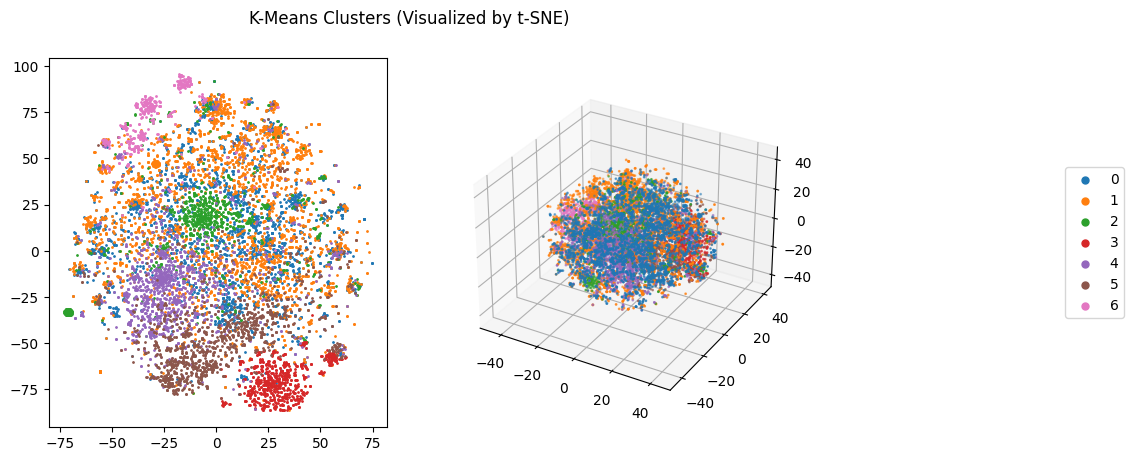

In [14]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [15]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,2607.0,7.0,397.0,"('mark@mark-story.com', 816)",71.0,4.0,"('saltstack_salt', 830)"
1,3009.0,7.0,396.0,"('thatch45@gmail.com', 1110)",71.0,4.0,"('saltstack_salt', 1673)"
2,963.0,7.0,71.0,"('mark@mark-story.com', 452)",34.0,2.0,"('cakephp_cakephp', 439)"
3,869.0,6.0,3.0,"('mike@silverorange.com', 841)",7.0,1.0,"('silverorange_swat', 841)"
4,1457.0,7.0,190.0,"('marijnh@gmail.com', 509)",48.0,2.0,"('saltstack_salt', 437)"
5,1325.0,7.0,94.0,"('marijnh@gmail.com', 627)",43.0,2.0,"('codemirror_CodeMirror', 530)"
6,454.0,4.0,43.0,"('pedro@algarvio.me', 367)",7.0,1.0,"('saltstack_salt', 443)"


In [16]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,6.428571,170.571429,40.142857,2.285714
std,940.816439,1.133893,164.619619,26.485396,1.253566
min,454.000000,4.000000,3.000000,7.000000,1.000000
25%,916.000000,6.500000,57.000000,20.500000,1.500000
50%,1325.000000,7.000000,94.000000,43.000000,2.000000
75%,2032.000000,7.000000,293.000000,59.500000,3.000000
max,3009.000000,7.000000,397.000000,71.000000,4.000000


In [17]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3
length_mean,81.064376,63.619940,59.891089,58.918605
length_std,62.171804,40.388660,48.811600,32.107456
n_uppercase_mean,3.925278,2.950150,2.019802,1.372093
n_uppercase_std,4.833296,2.581822,2.193511,1.555534
polarity_mean,0.015470,0.004084,0.008874,0.012452
polarity_std,0.180990,0.177453,0.149994,0.103606
subjectivity_mean,0.206110,0.156597,0.103288,0.063850
subjectivity_std,0.285276,0.272525,0.208764,0.174689


In [18]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed due to the Member.PasswordEncyrption property changing from an ENUM to Varchar.

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
2) 
BUGFIX: Make sure CMS link knows when its currently in the CMS (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
3) 
MINOR ArrayLib - removed unncessary extending of Object since this class only has a bunch of static functions (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
4) 
BackURL from request rather than URL param

No url mapping to $BackURL is defined anywhere in code,
so this condition would never be met. Setting BackURL
from form data makes more sense, and replica